# Capstone Project 2: Cleburne Student Data - Predicting STAAR placement

In [138]:
#Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score,log_loss
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns

### Loading Data

In [61]:
df = pd.read_csv('c3wrangled.csv')
df.iloc[:,:10].describe()

,Unnamed: 0,Student Number,Campus Number,Economic Disadvantage Category
count,423.000000,423.000000,423.000000,423.000000
mean,213.777778,214.777778,4.264775,1.170213
std,123.685037,123.685037,1.889322,1.393744
min,0.000000,1.000000,1.000000,0.000000
25%,107.500000,108.500000,3.000000,0.000000
50%,213.000000,214.000000,4.000000,0.000000
75%,320.500000,321.500000,6.000000,3.000000
max,432.000000,433.000000,7.000000,3.000000


In [62]:
df.drop(columns = ['Unnamed: 0', 'Student Number'], inplace=True)

In [63]:
nums = df[['Discipline Placement Incidents', 'STAAR Progress from 2019']]

In [64]:
scaler = StandardScaler()
nums_scaled = pd.DataFrame(scaler.fit_transform(nums), columns= nums.columns)

In [65]:
dfcat = df.drop(columns = ['Economic Disadvantage Category', 'Discipline Placement Incidents', 'STAAR Progress from 2019'])

In [66]:
dfcat = df.astype({"Campus Number": str, "Target": str, "Military Connected Student": str, 'Economic Disadvantage Category': str})

In [67]:
dfcat.drop(columns=['Grade Level', 'STAAR Progress from 2019', 'Discipline Placement Incidents'], inplace=True)

In [68]:
dfcat = pd.get_dummies(dfcat.drop(columns=['Target']))
dfcat['Target'] = df['Target']

In [69]:
dfcat.head()

,Campus Number_1,Campus Number_2,Campus Number_3,Campus Number_4,Campus Number_5,Campus Number_6,Campus Number_7,Gender_Female,Gender_Male,EthnicityRace_African American,...,Tested Language_S,Military Connected Student_0,Military Connected Student_1,>=50.0% Remote SY 2020-21_No,>=50.0% Remote SY 2020-21_Yes,Oral Administration_No,Oral Administration_Yes,Test Admin Mode_Online,Test Admin Mode_Paper,Target
0,1,0,0,0,0,0,0,1,0,0,...,0,1,0,0,1,1,0,1,0,0
1,0,0,1,0,0,0,0,1,0,0,...,0,1,0,1,0,0,1,0,1,0
2,0,0,0,0,0,0,1,0,1,0,...,0,1,0,1,0,1,0,1,0,2
3,0,0,0,0,1,0,0,1,0,0,...,0,1,0,1,0,1,0,1,0,0
4,0,0,1,0,0,0,0,0,1,0,...,0,1,0,1,0,1,0,1,0,1


In [70]:
df = pd.concat([dfcat, nums_scaled], axis = 1)

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423 entries, 0 to 422
Data columns (total 47 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Campus Number_1                                  423 non-null    uint8  
 1   Campus Number_2                                  423 non-null    uint8  
 2   Campus Number_3                                  423 non-null    uint8  
 3   Campus Number_4                                  423 non-null    uint8  
 4   Campus Number_5                                  423 non-null    uint8  
 5   Campus Number_6                                  423 non-null    uint8  
 6   Campus Number_7                                  423 non-null    uint8  
 7   Gender_Female                                    423 non-null    uint8  
 8   Gender_Male                                      423 non-null    uint8  
 9   EthnicityRace_African American  

In [72]:
df = df.astype({"Target": str})

In [73]:
X = df.drop(columns=['Target'])
y = df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

### Baseline Model

I'll be using A logistic regression categorization model without optimization through gridsearch to determine a baseline. 

In [74]:
lrmodel = LogisticRegression()
lrmodel.fit(X_train, y_train)
lr_y_pred = lrmodel.predict(X_test)
lr_accuracy = lrmodel.score(X_test, y_test)
lr_f1 = f1_score(y_test, lr_y_pred, average='weighted')

C:\Users\Armstrongs\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [75]:
print('Logist Regression: Accuracy=%.3f' % (lr_accuracy))

print('Logist Regression: f1-score=%.3f' % (lr_f1))

Logist Regression: Accuracy=0.506
Logist Regression: f1-score=0.498


In [76]:
df['Target'].value_counts()

0    111
1    109
3    102
2    101
Name: Target, dtype: int64

Since the values of my target are roughly equal, I will use accuracy as my primary metric. However because of the nature of STAAR categorization I will also take a look at the confusion matrix.

In [77]:
class_names=[0, 1, 2, 3]

In [78]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], '.2f'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
#Adapted from the Random Forest Case study from Springboard

Normalized confusion matrix


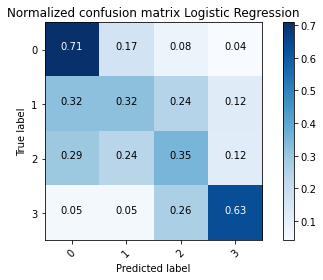

In [79]:
cnf_matrix = confusion_matrix(y_test, lr_y_pred)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Normalized confusion matrix Logistic Regression')

As is displayed above, logistic regression is good at predicting extreme values, but not those in the middle. This is non-optimum as unassisted human performed student analysis would have little trouble predicting the top and bottom performers. However, since there is much more accuracy at the extreme values I am going to also use machine learning to predict straight pass/fail per student for better accuracy. 

In [80]:
conditions = [
    (df['Target'] == '0'),
    (df['Target'] == '1'),
    (df['Target'] == '2'),
    (df['Target'] == '3')
    ]

values = [0, 1, 1, 1]

df['Pass'] = np.select(conditions, values)

df['Pass'].head()

0    0
1    0
2    1
3    0
4    1
Name: Pass, dtype: int32

In [81]:
y2 = df['Pass']
X2 = df.drop(columns=['Pass', 'Target'])
sX_train, sX_test, sy_train, sy_test = train_test_split(X2, y2, test_size=.2, random_state=42)

In [82]:
slrmodel = LogisticRegression()
slrmodel.fit(sX_train, sy_train)
slr_y_pred = slrmodel.predict(sX_test)
slr_accuracy = slrmodel.score(sX_test, sy_test)
slr_f1 = f1_score(sy_test, slr_y_pred, average='weighted')

In [83]:
print('Pass/Fail Logist Regression: Accuracy=%.3f' % (slr_accuracy))

print('Pass/Fail Logist Regression: f1-score=%.3f' % (slr_f1))

Pass/Fail Logist Regression: Accuracy=0.800
Pass/Fail Logist Regression: f1-score=0.792


### Gridsearch Tuned Logistic Regression

In [89]:
grid={"C":np.logspace(-3,3,7)}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train,y_train)
#Code above adapted from https://www.kaggle.com/enespolat/grid-search-with-logistic-regression

C:\Users\Armstrongs\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Armstrongs\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\Armstrongs\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Armstrongs\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\Armstrongs\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Armstrongs\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])})

In [90]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 10.0}
accuracy : 0.48226381461675577


In [93]:
tlrmodel = LogisticRegression(C = 10)
tlrmodel.fit(X_train, y_train)
tlr_y_pred = tlrmodel.predict(X_test)
tlr_accuracy = tlrmodel.score(X_test, y_test)
tlr_f1 = f1_score(y_test, tlr_y_pred, average='weighted')

C:\Users\Armstrongs\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [94]:
print('tLogist Regression: Accuracy=%.3f' % (tlr_accuracy))

print('tLogist Regression: f1-score=%.3f' % (tlr_f1))

Logist Regression: Accuracy=0.494
Logist Regression: f1-score=0.488


In [95]:
#Talk to mentor about losing accuracy and f1 after tuning

### Random Forest

In [101]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
#Adapted from Random Forest Case Study Springboard

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [102]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 90,
 'bootstrap': True}

In [107]:
clf = RandomForestClassifier(n_estimators=1000, min_samples_split = 10, min_samples_leaf = 2, max_features = 'sqrt', \
                            max_depth = 10, bootstrap = True)
model_res = clf.fit(X_train, y_train)
rfy_pred = model_res.predict(X_test)
rfy_pred_prob = model_res.predict_proba(X_test)
lr_probs = rfy_pred_prob[:,1]
rfac = accuracy_score(y_test, rfy_pred)

rff1 = f1_score(y_test, rfy_pred, average='weighted')
rfcm = confusion_matrix(y_test, rfy_pred)

print('Random Forest: Accuracy=%.3f' % (rfac))

print('Random Forest: f1-score=%.3f' % (rff1))

Random Forest: Accuracy=0.529
Random Forest: f1-score=0.524


Normalized confusion matrix


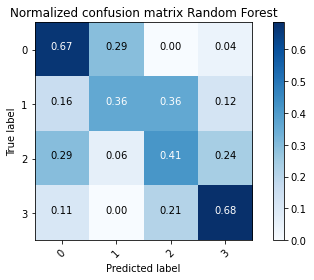

In [109]:
cnf_matrix = confusion_matrix(y_test, rfy_pred)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Normalized confusion matrix Random Forest')

In [170]:
feature_importances = pd.DataFrame(clf.feature_importances_, index = X.columns, columns = ['importance']).sort_values('importance', ascending = False)
print(feature_importances.head(10))
print(feature_importances.tail(10))
#idea above inspire by Derek Samsom https://github.com/DerekSamsom/Capstone1-Predicting_Loan_ROI/blob/master/Code/Capstone_Project_1_In_Depth_Analysis.ipynb

                                  importance
STAAR Progress from 2019            0.174185
Special Ed_No                       0.071869
At Risk_Yes                         0.071139
Special Ed_Yes                      0.070265
At Risk_No                          0.069043
Campus Number_6                     0.039791
Campus Number_5                     0.031857
Economic Disadvantage Category_0    0.031689
EthnicityRace_White                 0.026588
Economic Disadvantage_Yes           0.025546
                                                 importance
Economic Disadvantage Category_2                   0.005226
EthnicityRace_Two or More                          0.004908
>=50.0% Remote SY 2020-21_No                       0.004311
>=50.0% Remote SY 2020-21_Yes                      0.003437
EthnicityRace_Asian                                0.000082
Military Connected Student_1                       0.000076
EthnicityRace_American Indian or Alaskan Native    0.000070
Military Connected Studen

In [172]:
#I wonder how the model would perform if I removed some of the less useful features. 
drop_cols_rf = list(feature_importances[feature_importances.importance < 0.0015].index)
drop_cols_rf

['EthnicityRace_Asian',
 'Military Connected Student_1',
 'EthnicityRace_American Indian or Alaskan Native',
 'Military Connected Student_0',
 'Tested Language_E',
 'Tested Language_S']

In [173]:
X3 = X.drop(drop_cols_rf, axis = 1)

In [177]:
redX_train, redX_test, redy_train, redy_test = train_test_split(X3, y, test_size = 0.2, random_state=42)

In [178]:
redmodel_res = clf.fit(redX_train, redy_train)
redrfy_pred = redmodel_res.predict(redX_test)
redrfy_pred_prob = redmodel_res.predict_proba(redX_test)
redlr_probs = redrfy_pred_prob[:,1]
redrfac = accuracy_score(redy_test, redrfy_pred)

redrff1 = f1_score(redy_test, redrfy_pred, average='weighted')
redrfcm = confusion_matrix(redy_test, redrfy_pred)

print('Reduced Random Forest: Accuracy=%.3f' % (redrfac))

print('Reduced Random Forest: f1-score=%.3f' % (redrff1))

Reduced Random Forest: Accuracy=0.518
Reduced Random Forest: f1-score=0.514


Random Forest Slightly outperforms Logistic Regression with the added bonus of increased accuracy for the middle values. Suprisingly it loses some performance when culling low imporance features. Now I will examine how it performs on the pass/fail set

In [111]:
smodel_res = clf.fit(sX_train, sy_train)
srfy_pred = model_res.predict(sX_test)
srfy_pred_prob = model_res.predict_proba(sX_test)
lr_probs = srfy_pred_prob[:,1]
srfac = accuracy_score(sy_test, srfy_pred)

srff1 = f1_score(sy_test, srfy_pred, average='weighted')
srfcm = confusion_matrix(sy_test, srfy_pred)

print('Random Forest: Accuracy=%.3f' % (srfac))

print('Random Forest: f1-score=%.3f' % (srff1))

Random Forest: Accuracy=0.765
Random Forest: f1-score=0.736


Suprisingly the random forest model is less effective at the pass/fail set.

### Gradient Boosting

In [116]:
gbscoring= ['accuracy', 'precision','recall']
gbparameters = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]}
gb = GradientBoostingClassifier()
gb_random = RandomizedSearchCV(estimator = gb, param_distributions = gbparameters, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
gb_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'criterion': ['friedman_mse', 'mae'],
                                        'learning_rate': [0.01, 0.025, 0.05,
                                                          0.075, 0.1, 0.15,
                                                          0.2],
                                        'loss': ['deviance'],
                                        'max_depth': [3, 5, 8],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': array([0.1 , 0.14, 0.17, 0.21, 0.25, 0.28, 0.32, 0.35, 0.39, 0.43, 0.46,
       0.5 ]),
                                        'min_samples_split': array([0.1 , 0.14, 0.17, 0.21, 0.25, 0.28, 0.32, 0.35, 0.39, 0.43, 0.46,
       0.5 ]),
                                        'n_estimators': [10],
                                       

In [117]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 90,
 'bootstrap': True}

In [130]:
gbmodel = GradientBoostingClassifier(n_estimators = 400, min_samples_split = 10, min_samples_leaf = 4, max_features = 'sqrt', max_depth = 90)
gbmodel.fit(X_train, y_train)
gby_pred = gbmodel.predict(X_test)
gby_pred_prob = gbmodel.predict_proba(X_test)
gb_probs = gby_pred_prob[:,1]
gbac = accuracy_score(y_test, gby_pred)

gbf1 = f1_score(y_test, gby_pred, average='weighted')
gbcm = confusion_matrix(y_test, gby_pred)

print('Gradient Boosting: Accuracy=%.3f' % (gbac))

print('Gradient Boosting: f1-score=%.3f' % (gbf1))

Gradient Boosting: Accuracy=0.506
Gradient Boosting: f1-score=0.491


Normalized confusion matrix


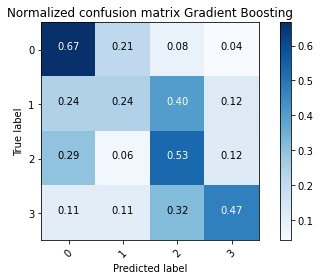

In [120]:
cnf_matrix = confusion_matrix(y_test, gby_pred)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Normalized confusion matrix Gradient Boosting')

In [132]:
gbmodel.fit(sX_train, sy_train)
sgby_pred = gbmodel.predict(sX_test)
sgby_pred_prob = gbmodel.predict_proba(sX_test)
sgb_probs = sgby_pred_prob[:,1]
sgbac = accuracy_score(sy_test, sgby_pred)

sgbf1 = f1_score(sy_test, sgby_pred, average='weighted')
sgbcm = confusion_matrix(sy_test, sgby_pred)

print('Gradient Boosting Pass/Fail: Accuracy=%.3f' % (sgbac))

print('Gradient Boosting Pass/Fail: f1-score=%.3f' % (sgbf1))

Random Forest: Accuracy=0.800
Random Forest: f1-score=0.799


Gradient Boosting performs slightly worse than random forrest in general but slightly better at the pass/fail set

### K-Nearest Neighbors

In [145]:
test_scores = []
train_scores = []

for i in range(1,20):

    knn = KNeighborsClassifier(i)
    knn.fit(X_train,y_train)
    
    train_scores.append(knn.score(X_train,y_train))
    test_scores.append(knn.score(X_test,y_test))

In [147]:
test_scores.index(max(test_scores))
#Here an index of 12 indicates 13 neighbors

12

C:\Users\Armstrongs\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Armstrongs\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


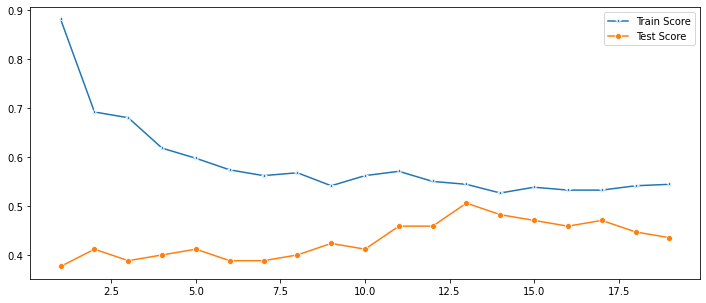

In [148]:
plt.figure(figsize=(12,5))
p = sns.lineplot(range(1,20),train_scores,marker='*',label='Train Score')
p = sns.lineplot(range(1,20),test_scores,marker='o',label='Test Score')

In [159]:
knn = KNeighborsClassifier(13)
knn.fit(X_train,y_train)
knny_pred = knn.predict(X_test)
knny_pred_prob = knn.predict_proba(X_test)
knn_probs = knny_pred_prob[:,1]
knnac = accuracy_score(y_test, knny_pred)

knnf1 = f1_score(y_test, knny_pred, average='weighted')
knncm = confusion_matrix(y_test, knny_pred)

print('KNN: Accuracy=%.3f' % (knnac))

print('KNN: f1-score=%.3f' % (knnf1))

KNN: Accuracy=0.506
KNN: f1-score=0.507


Normalized confusion matrix


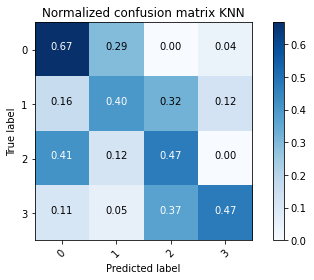

In [160]:
cnf_matrix = confusion_matrix(y_test, knny_pred)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Normalized confusion matrix KNN')

In [179]:
print('Base Logistic Regression: Accuracy=%.3f' % (lr_accuracy))

print('Base Logistic Regression: f1-score=%.3f' % (lr_f1))

print('Logist Regression: Accuracy=%.3f' % (tlr_accuracy))

print('Logist Regression: f1-score=%.3f' % (tlr_f1))
print('Random Forest: Accuracy=%.3f' % (rfac))

print('Random Forest: f1-score=%.3f' % (rff1))
print('Reduced Random Forest: Accuracy=%.3f' % (redrfac))

print('Reduced Random Forest: f1-score=%.3f' % (redrff1))
print('Gradient Boosting: Accuracy=%.3f' % (gbac))

print('Gradient Boosting: f1-score=%.3f' % (gbf1))
print('KNN: Accuracy=%.3f' % (knnac))

print('KNN: f1-score=%.3f' % (knnf1))

Base Logistic Regression: Accuracy=0.506
Base Logistic Regression: f1-score=0.498
Logist Regression: Accuracy=0.494
Logist Regression: f1-score=0.488
Random Forest: Accuracy=0.529
Random Forest: f1-score=0.524
Reduced Random Forest: Accuracy=0.518
Reduced Random Forest: f1-score=0.514
Gradient Boosting: Accuracy=0.506
Gradient Boosting: f1-score=0.491
KNN: Accuracy=0.506
KNN: f1-score=0.507


It appears that the best model in terms of both accuracy and f1 scores is Random Forest.

In [163]:
test_scores = []
train_scores = []

for i in range(1,20):

    knn = KNeighborsClassifier(i)
    knn.fit(sX_train,sy_train)
    
    train_scores.append(knn.score(sX_train,sy_train))
    test_scores.append(knn.score(sX_test,sy_test))

In [164]:
test_scores.index(max(test_scores))
#Here an index of 14 indicates 15 neighbors

14

C:\Users\Armstrongs\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Armstrongs\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


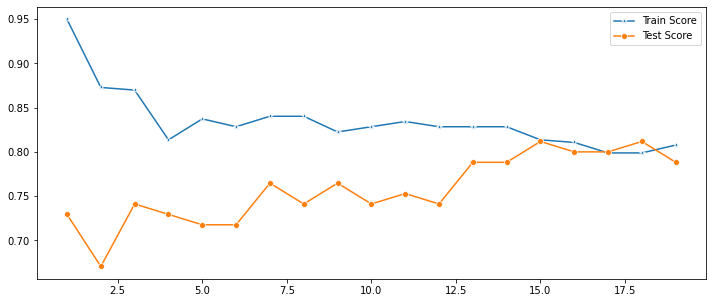

In [165]:
plt.figure(figsize=(12,5))
p = sns.lineplot(range(1,20),train_scores,marker='*',label='Train Score')
p = sns.lineplot(range(1,20),test_scores,marker='o',label='Test Score')

In [167]:
sknn = KNeighborsClassifier(15)
sknn.fit(sX_train,sy_train)
sknny_pred = knn.predict(sX_test)
sknny_pred_prob = sknn.predict_proba(sX_test)
sknn_probs = sknny_pred_prob[:,1]
sknnac = accuracy_score(sy_test, sknny_pred)

sknnf1 = f1_score(sy_test, sknny_pred, average='weighted')
sknncm = confusion_matrix(sy_test,sknny_pred)

print('Pass/Fail KNN: Accuracy=%.3f' % (sknnac))

print('Pass/Fail KNN: f1-score=%.3f' % (sknnf1))

KNN: Accuracy=0.788
KNN: f1-score=0.768


In [168]:
print('Pass/Fail Logist Regression: Accuracy=%.3f' % (slr_accuracy))

print('Pass/Fail Logist Regression: f1-score=%.3f' % (slr_f1))
print('Pass/Fail Random Forest: Accuracy=%.3f' % (srfac))

print('Pass/Fail Random Forest: f1-score=%.3f' % (srff1))
print('Gradient Boosting Pass/Fail: Accuracy=%.3f' % (sgbac))

print('Gradient Boosting Pass/Fail: f1-score=%.3f' % (sgbf1))
print('Pass/Fail KNN: Accuracy=%.3f' % (sknnac))

print('Pass/Fail KNN: f1-score=%.3f' % (sknnf1))

Pass/Fail Logist Regression: Accuracy=0.800
Pass/Fail Logist Regression: f1-score=0.792
Pass/Fail Random Forest: Accuracy=0.765
Pass/Fail Random Forest: f1-score=0.736
Gradient Boosting Pass/Fail: Accuracy=0.800
Gradient Boosting Pass/Fail: f1-score=0.799
Pass/Fail KNN: Accuracy=0.788
Pass/Fail KNN: f1-score=0.768


However, in terms of Pass/Fail the Gradient Boosting model wins out by a small margin. In this case the random forrest is actually the *least* performing model

## Findings / Suggestions

The top performing model was able to predict with reasonable accuracy the top and bottom performing students. Most teachers would be able to do the same after having worked with a student for a grading period. However the benefit here is that these results were not based on any academic data (with the exception of special education status), only inherent student demographic data as well relative staar progress. This means that resources could be targeted at specific students much earlier than traditional teacher recommendation methods would allow. It is interesting to note that the most important features for the algorithm were relative staar progress from the previous year, special ed status, economic status, and whether or not the student attended campuses 5 and 6, just as EDA suggested. It is also worth noting that whether the student took the test in Spanish or English was of no use to the algorithm, although the small sample size may be a contributing factor in this case. 

It is unfortunate that no algorithm was able to predict Approaches and Meets level students with a high level of accuracy as these are the students where it is likely to be most important to focus resources on. In the future, an algorithm could be trained on specific math academic data on a student by student basis, a pipeline could then automatically learn from the data as more grades were input into the system, and a recommendation could automatically be produced on a periodic basis. 